## LAB 8
## MohammadParsa Dini 400101204

# PART 1:
##### Using your laptop's webcam, implement optical flow in real-time using two methods: dense and sparse. In the dense method, calculate the optical flow for all the pixels on the screen.

In [1]:
import cv2
import numpy as np
import time

# Initialize the webcam
cap = cv2.VideoCapture(0)

# Get the video frame width and height
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define the video writers for dense and sparse optical flow
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out_dense = cv2.VideoWriter('dense_optical_flow.avi', fourcc, 20.0, (frame_width, frame_height))
out_sparse = cv2.VideoWriter('sparse_optical_flow.avi', fourcc, 20.0, (frame_width, frame_height))

# Parameters for ShiTomasi corner detection (used in sparse method)
feature_params = dict(maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)

# Parameters for Lucas-Kanade optical flow (used in sparse method)
lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Random colors for visualization
color = np.random.randint(0, 255, (100, 3))

# Capture the first frame and convert it to grayscale
ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)  # Initial points for sparse optical flow

# Create a mask image for drawing purposes (for sparse method)
mask = np.zeros_like(old_frame)

# Set the timer for 10 seconds
start_time = time.time()

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert current frame to grayscale
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    ### Dense Optical Flow using Farneback's method ###
    flow = cv2.calcOpticalFlowFarneback(old_gray, frame_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv = np.zeros_like(frame)
    hsv[..., 1] = 255
    hsv[..., 0] = ang * 180 / np.pi / 2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    dense_flow = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    ### Sparse Optical Flow using Shi-Tomasi and Lucas-Kanade ###
    if p0 is not None:
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
        good_new = p1[st == 1]
        good_old = p0[st == 1]

        for i, (new, old) in enumerate(zip(good_new, good_old)):
            a, b = new.ravel()
            c, d = old.ravel()
            mask = cv2.line(mask, (int(a), int(b)), (int(c), int(d)), color[i].tolist(), 2)
            frame = cv2.circle(frame, (int(a), int(b)), 5, color[i].tolist(), -1)

        sparse_flow = cv2.add(frame, mask)

    # Save frames to video files
    out_dense.write(dense_flow)
    if p0 is not None:
        out_sparse.write(sparse_flow)

    # Display both dense and sparse optical flow
    cv2.imshow("Dense Optical Flow", dense_flow)
    if p0 is not None:
        cv2.imshow("Sparse Optical Flow", sparse_flow)

    # Update previous frame and points for sparse optical flow
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1, 1, 2) if p0 is not None else None

    # Check if 10 seconds have passed
    if time.time() - start_time > 10:
        print("Recording complete. Closing webcam...")
        break

    # Exit on pressing 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        print("User terminated the recording.")
        break

# Release resources and close windows
cap.release()
out_dense.release()
out_sparse.release()
cv2.destroyAllWindows()

print("Videos saved: 'dense_optical_flow.avi' and 'sparse_optical_flow.avi'")



Recording complete. Closing webcam...
Videos saved: 'dense_optical_flow.avi' and 'sparse_optical_flow.avi'


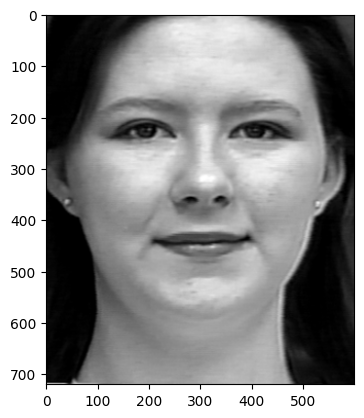

: 

In [1]:
import cv2
import os
import matplotlib.pyplot as plt 

frame_path = r"C:\Users\USER\Downloads\Cohn-Kanade\videos\happy videos\S078\S078_004_00015217.png"  

# Read the image
image = cv2.imread(frame_path)

if image is not None:
    # Get the width and height of the image
    height, width = image.shape[:2]

    # Crop the image by removing the specified pixels
    cropped = image[60:height-120, 300:width-300]
    
    # Optionally save or display the cropped image
    cropped_image_path = os.path.join(os.path.dirname(frame_path), 'cropped_S078.jpg')
    cv2.imwrite(cropped_image_path, cropped)
    
    # Display the cropped image
    cv2.imshow("Cropped Image", cropped)
    plt.imshow(cropped)
else:
    print(f"Error: Unable to load image from {frame_path}")
    
    


In [12]:
import cv2
import os
import matplotlib.pyplot as plt 
import glob

def crop_image(w1, w2, h1, h2, image):
    height , width = image.shape[:2]
    cropped = image[h1:height-h2, w1:width-w2]
    return cropped

# Function to calculate optical flow between two frames
def calculate_optical_flow(prev_frame, next_frame):
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    next_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)
    
    flow = cv2.calcOpticalFlowFarneback(prev_gray, next_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    return flow

# Function to compute histogram of optical flow angles with 8 bins
def compute_histogram(flow, bins=8):
    # Calculate magnitude and angle
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    
    # Calculate the histogram of angles, weighted by the magnitude
    hist = np.histogram(ang, bins=bins, range=(0, 2 * np.pi), weights=mag)
    return hist[0]

# Function to process all frames in the folder and compute histograms
def process_frames_in_folder(frame_folder):
    # Get all JPEG files in the folder
    frame_paths = sorted(glob.glob(os.path.join(frame_folder, "*.png")))  # Assuming frames are in .jpg format
    
    histograms = []
    
    #print(len(frame_paths))
    # Loop over the frames and calculate optical flow between consecutive frames
    for i in range(1, len(frame_paths)):
        prev_frame = cv2.imread(frame_paths[i - 1])
        prev_frame = crop_image(300,300,60,120,prev_frame)
        next_frame = cv2.imread(frame_paths[i])
        next_frame = crop_image(300,300,60,120,next_frame)
        
        if prev_frame is None or next_frame is None:
            continue
        
        # Compute optical flow between consecutive frames
        flow = calculate_optical_flow(prev_frame, next_frame)
        
        # Compute histogram for this pair of frames
        hist = compute_histogram(flow)
        
        # Append the histogram to the list
        histograms.append(hist)
    
    # Return the list of histograms
    return np.array(histograms)

# Example usage
frame_folder = r"C:\Users\USER\Downloads\Cohn-Kanade\videos\happy videos\S079"
histograms = process_frames_in_folder(frame_folder)

# Print the shape of histograms (number of frames, number of bins)
print("Histograms shape:", histograms.shape)






Histograms shape: (25, 8)


This code processes video frames to analyze motion patterns by computing optical flow histograms. It begins by cropping each frame to remove unnecessary portions, focusing on a specific region of interest. Then, the code calculates the optical flow between consecutive frames using the Farneback method, which captures the direction and magnitude of motion. The flow data is converted into histograms that represent the angular distribution of motion, weighted by the magnitude, across eight bins.

By processing all consecutive frame pairs in a folder, the code generates a series of histograms capturing the temporal motion patterns throughout the video. These histograms can serve as feature representations for downstream tasks like classification or pattern recognition. The example usage processes frames from a specified folder, computes histograms, and prints their dimensions to ensure the feature extraction pipeline works as expected. This approach provides a structured way to convert video data into meaningful motion descriptors.

### PART 2

Histograms shape: (25, 8)


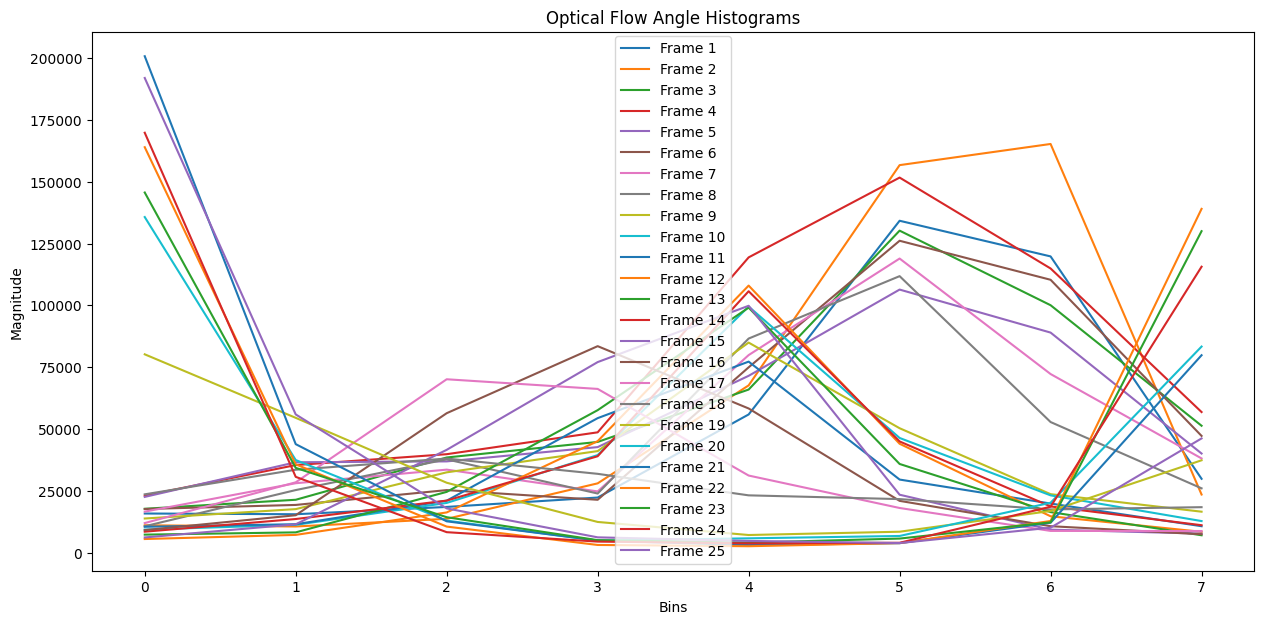

Average Histogram (Video Descriptor): [53142.28  25676.512 27599.965 33290.27  57586.145 56298.24  43585.24
 42112.48 ]


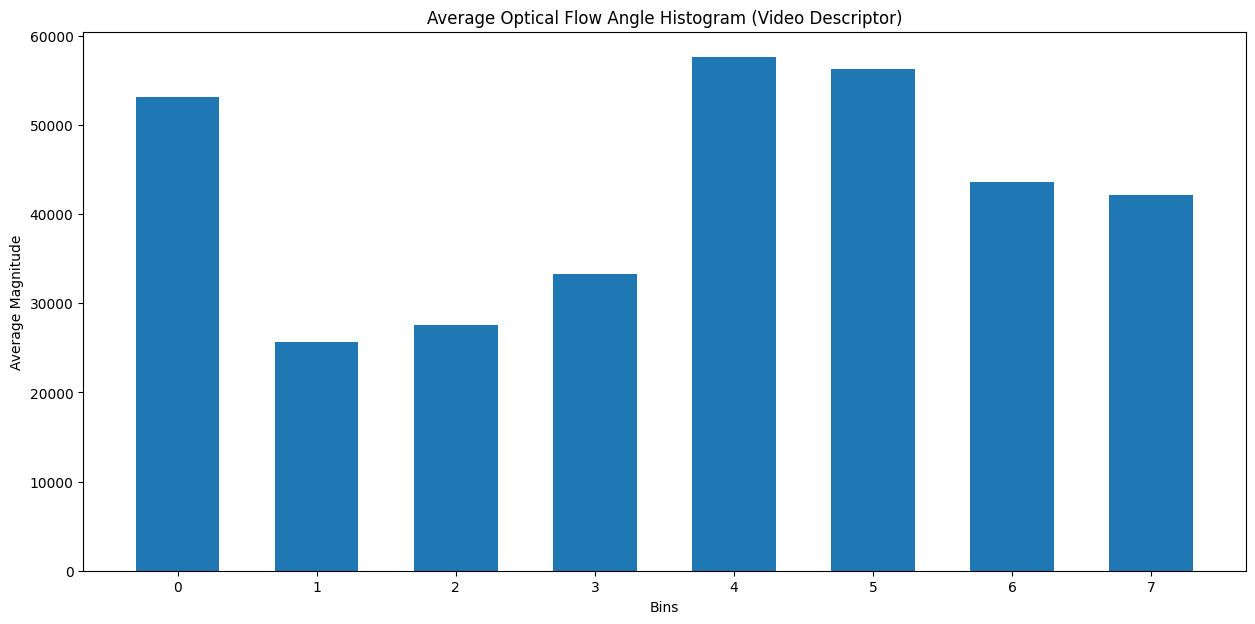

In [15]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import glob

# Function to crop an image
def crop_image(w1, w2, h1, h2, image):
    height, width = image.shape[:2]
    cropped = image[h1:height-h2, w1:width-w2]
    return cropped

# Function to calculate optical flow between two frames
def calculate_optical_flow(prev_frame, next_frame):
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    next_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)
    
    flow = cv2.calcOpticalFlowFarneback(prev_gray, next_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    return flow

# Function to compute histogram of optical flow angles with 8 bins
def compute_histogram(flow, bins=8):
    # Calculate magnitude and angle
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    
    # Calculate the histogram of angles, weighted by the magnitude
    hist, _ = np.histogram(ang, bins=bins, range=(0, 2 * np.pi), weights=mag)
    return hist

# Function to process all frames in the folder and compute histograms
def process_frames_in_folder(frame_folder):
    # Get all PNG files in the folder
    frame_paths = sorted(glob.glob(os.path.join(frame_folder, "*.png")))  # Assuming frames are in .png format
    
    histograms = []
    
    # Loop over the frames and calculate optical flow between consecutive frames
    for i in range(1, len(frame_paths)):
        prev_frame = cv2.imread(frame_paths[i - 1])
        prev_frame = crop_image(300, 300, 60, 120, prev_frame)
        next_frame = cv2.imread(frame_paths[i])
        next_frame = crop_image(300, 300, 60, 120, next_frame)
        
        if prev_frame is None or next_frame is None:
            continue
        
        # Compute optical flow between consecutive frames
        flow = calculate_optical_flow(prev_frame, next_frame)
        
        # Compute histogram for this pair of frames
        hist = compute_histogram(flow)
        
        # Append the histogram to the list
        histograms.append(hist)
    
    # Return the list of histograms
    return np.array(histograms)

# Plot histograms for each frame
def plot_histograms(histograms):
    plt.figure(figsize=(15, 7))
    for i, hist in enumerate(histograms):
        plt.plot(hist, label=f"Frame {i + 1}")
    plt.xlabel("Bins")
    plt.ylabel("Magnitude")
    plt.title("Optical Flow Angle Histograms")
    plt.legend()
    plt.show()

# Example usage
frame_folder = r"C:\Users\USER\Downloads\Cohn-Kanade\videos\happy videos\S079"
histograms = process_frames_in_folder(frame_folder)

# Print the shape of histograms (number of frames, number of bins)
print("Histograms shape:", histograms.shape)

# Plot histograms
plot_histograms(histograms)

# Compute average histogram for the video (descriptor)
average_histogram = np.mean(histograms, axis=0)
print("Average Histogram (Video Descriptor):", average_histogram)

# Plot average histogram
plt.figure(figsize=(15, 7))
plt.bar(range(len(average_histogram)), average_histogram, width=0.6, align='center')
plt.xlabel("Bins")
plt.ylabel("Average Magnitude")
plt.title("Average Optical Flow Angle Histogram (Video Descriptor)")
plt.show()


In [5]:
import os
import cv2
import numpy as np
import glob
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import torch

# Check CUDA availability
if torch.cuda.is_available():
    torch.device = 'cuda'
else:
    torch.device = 'cpu'
device = torch.device
print("Using device:", device)

# Function to crop the image
def crop_image(w1, w2, h1, h2, image):
    height, width = image.shape[:2]
    if height <= (h1 + h2) or width <= (w1 + w2):
        raise ValueError(f"Image dimensions ({height}, {width}) are too small for cropping.")
    cropped = image[h1:height-h2, w1:width-w2]
    return cropped

# Function to calculate optical flow between two frames
def calculate_optical_flow(prev_frame, next_frame):
    if prev_frame is None or next_frame is None:
        raise ValueError("Frames are None, cannot calculate optical flow.")
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    next_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(prev_gray, next_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    return flow

# Function to compute histogram of optical flow angles
def compute_histogram(flow, bins=8):
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hist = np.histogram(ang, bins=bins, range=(0, 2 * np.pi), weights=mag)
    return hist[0]

# Function to process all frames in a folder and compute histograms
def process_video_histograms(frame_folder, bins=8):
    frame_paths = sorted(glob.glob(os.path.join(frame_folder, "*.png")))
    #print(f"Processing folder: {frame_folder}")
    #print(f"Found frames: {frame_paths}")

    histograms = []

    for i in range(1, len(frame_paths)):
        #print(f"Processing frames {frame_paths[i - 1]} and {frame_paths[i]}")
        prev_frame = cv2.imread(frame_paths[i - 1])
        next_frame = cv2.imread(frame_paths[i])

        if prev_frame is None or next_frame is None:
            #print(f"Failed to load frames: {frame_paths[i - 1]} or {frame_paths[i]}")
            continue

        # Ensure dimensions are sufficient for cropping
        try:
            prev_frame = crop_image(300, 300, 60, 120, prev_frame)
            next_frame = crop_image(300, 300, 60, 120, next_frame)
        except ValueError as e:
            print(e)
            continue

        # Compute optical flow
        flow = calculate_optical_flow(prev_frame, next_frame)

        # Compute histogram
        hist = compute_histogram(flow, bins)
        histograms.append(hist)

    return np.array(histograms)

# Function to create video descriptor by pooling
def create_video_descriptor(histograms):
    if histograms.size == 0:
        return None
    avg_hist = np.mean(histograms, axis=0)   # avg
    max_hist = np.max(histograms, axis=0)    # max 
    descriptor = np.concatenate((avg_hist, max_hist))
    return descriptor

# Process videos in a folder and create descriptors
def process_videos_in_folder(video_folder):
    descriptors = []
    video_paths = sorted(glob.glob(os.path.join(video_folder, "*")))
    #print(f"Processing videos in folder: {video_folder}")

    for video_path in video_paths:
        #print(f"Processing video: {video_path}")
        histograms = process_video_histograms(video_path)
        descriptor = create_video_descriptor(histograms)
        if descriptor is not None:
            descriptors.append(descriptor)
    return np.array(descriptors)

# Paths to video folders
happy_folder = r"C:\Users\USER\Downloads\Cohn-Kanade\videos\happy videos"
surprise_folder = r"C:\Users\USER\Downloads\Cohn-Kanade\videos\surprise videos"

# Debug folder contents
print(f"Happy folder contents: {os.listdir(happy_folder)}")
print(f"Surprise folder contents: {os.listdir(surprise_folder)}")

# Process videos in both folders
happy_descriptors = process_videos_in_folder(happy_folder)
surprise_descriptors = process_videos_in_folder(surprise_folder)

# Create labels for the descriptors
happy_labels = np.ones(len(happy_descriptors))
surprise_labels = np.zeros(len(surprise_descriptors))

# Combine descriptors and labels
X = np.vstack((happy_descriptors, surprise_descriptors))
y = np.hstack((happy_labels, surprise_labels))

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

# Print results
print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])

# Train an SVM classifier
clf = SVC(kernel='linear', random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print the classification report
print("Test Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Using device: cuda
Happy folder contents: ['S010', 'S011', 'S014', 'S022', 'S026', 'S032', 'S035', 'S037', 'S042', 'S050', 'S057', 'S060', 'S063', 'S064', 'S065', 'S066', 'S067', 'S069', 'S070', 'S071', 'S072', 'S073', 'S074', 'S075', 'S076', 'S077', 'S078', 'S079', 'S080', 'S081']
Surprise folder contents: ['S010', 'S011', 'S014', 'S022', 'S026', 'S032', 'S034', 'S035', 'S037', 'S042', 'S044', 'S046', 'S050', 'S052', 'S053', 'S055', 'S057', 'S058', 'S059', 'S061', 'S062', 'S063', 'S064', 'S065', 'S066', 'S067', 'S069', 'S070', 'S071', 'S072']
Processing videos in folder: C:\Users\USER\Downloads\Cohn-Kanade\videos\happy videos
Processing video: C:\Users\USER\Downloads\Cohn-Kanade\videos\happy videos\S010
Processing folder: C:\Users\USER\Downloads\Cohn-Kanade\videos\happy videos\S010
Found frames: ['C:\\Users\\USER\\Downloads\\Cohn-Kanade\\videos\\happy videos\\S010\\S010_006_01594615.png', 'C:\\Users\\USER\\Downloads\\Cohn-Kanade\\videos\\happy videos\\S010\\S010_006_01594616.png', 'C:

In [6]:
print("Test Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Test Accuracy: 0.6111111111111112

Classification Report:
               precision    recall  f1-score   support

         0.0       0.71      0.50      0.59        10
         1.0       0.55      0.75      0.63         8

    accuracy                           0.61        18
   macro avg       0.63      0.62      0.61        18
weighted avg       0.64      0.61      0.61        18



In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Check CUDA availability
if torch.cuda.is_available():
    torch.device = 'cuda'
else:
    torch.device = 'cpu'
device = torch.device
print("Using device:", device)

# Function to crop the image
def crop_image(w1, w2, h1, h2, image):
    height, width = image.shape[:2]
    if height <= (h1 + h2) or width <= (w1 + w2):
        raise ValueError(f"Image dimensions ({height}, {width}) are too small for cropping.")
    cropped = image[h1:height-h2, w1:width-w2]
    return cropped

# Function to calculate optical flow between two frames
def calculate_optical_flow(prev_frame, next_frame):
    if prev_frame is None or next_frame is None:
        raise ValueError("Frames are None, cannot calculate optical flow.")
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    next_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(prev_gray, next_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    return flow

# Function to compute histogram of optical flow angles
def compute_histogram(flow, bins=8):
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hist = np.histogram(ang, bins=bins, range=(0, 2 * np.pi), weights=mag)
    return hist[0]

# Function to process all frames in a folder and compute histograms
def process_video_histograms(frame_folder, bins=8):
    frame_paths = sorted(glob.glob(os.path.join(frame_folder, "*.png")))
    #print(f"Processing folder: {frame_folder}")
    #print(f"Found frames: {frame_paths}")

    histograms = []

    for i in range(1, len(frame_paths)):
        #print(f"Processing frames {frame_paths[i - 1]} and {frame_paths[i]}")
        prev_frame = cv2.imread(frame_paths[i - 1])
        next_frame = cv2.imread(frame_paths[i])

        if prev_frame is None or next_frame is None:
            #print(f"Failed to load frames: {frame_paths[i - 1]} or {frame_paths[i]}")
            continue

        # Ensure dimensions are sufficient for cropping
        try:
            prev_frame = crop_image(300, 300, 60, 120, prev_frame)
            next_frame = crop_image(300, 300, 60, 120, next_frame)
        except ValueError as e:
            print(e)
            continue

        # Compute optical flow
        flow = calculate_optical_flow(prev_frame, next_frame)

        # Compute histogram
        hist = compute_histogram(flow, bins)
        histograms.append(hist)

    return np.array(histograms)

# Function to create video descriptor by pooling
def create_video_descriptor(histograms):
    if histograms.size == 0:
        return None
    avg_hist = np.mean(histograms, axis=0)
    max_hist = np.max(histograms, axis=0)
    descriptor = np.concatenate((avg_hist, max_hist))
    return descriptor

# Process videos in a folder and create descriptors
def process_videos_in_folder(video_folder):
    descriptors = []
    video_paths = sorted(glob.glob(os.path.join(video_folder, "*")))
    #print(f"Processing videos in folder: {video_folder}")

    for video_path in video_paths:
        #print(f"Processing video: {video_path}")
        histograms = process_video_histograms(video_path)
        descriptor = create_video_descriptor(histograms)
        if descriptor is not None:
            descriptors.append(descriptor)
    return np.array(descriptors)

happy_folder = r"C:\Users\USER\Downloads\Cohn-Kanade\videos\happy videos"
surprise_folder = r"C:\Users\USER\Downloads\Cohn-Kanade\videos\surprise videos"

# Debug folder contents
print(f"Happy folder contents: {os.listdir(happy_folder)}")
print(f"Surprise folder contents: {os.listdir(surprise_folder)}")

# Process videos in both folders
happy_descriptors = process_videos_in_folder(happy_folder)
surprise_descriptors = process_videos_in_folder(surprise_folder)

# Create labels for the descriptors
happy_labels = np.ones(len(happy_descriptors))
surprise_labels = np.zeros(len(surprise_descriptors))

# Combine descriptors and labels
X = np.vstack((happy_descriptors, surprise_descriptors))
y = np.hstack((happy_labels, surprise_labels))

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

# Print results
print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])

# Train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)  # Adjust 'n_estimators' if needed
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print the classification report
print("Test Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Using device: cuda
Happy folder contents: ['S010', 'S011', 'S014', 'S022', 'S026', 'S032', 'S035', 'S037', 'S042', 'S050', 'S057', 'S060', 'S063', 'S064', 'S065', 'S066', 'S067', 'S069', 'S070', 'S071', 'S072', 'S073', 'S074', 'S075', 'S076', 'S077', 'S078', 'S079', 'S080', 'S081']
Surprise folder contents: ['S010', 'S011', 'S014', 'S022', 'S026', 'S032', 'S034', 'S035', 'S037', 'S042', 'S044', 'S046', 'S050', 'S052', 'S053', 'S057', 'S058', 'S059', 'S061', 'S062', 'S063', 'S064', 'S065', 'S066', 'S067', 'S069', 'S070', 'S071', 'S072']
Image dimensions (720, 600) are too small for cropping.
Training set size: 41
Test set size: 18
Test Accuracy: 0.7777777777777778

Classification Report:
               precision    recall  f1-score   support

         0.0       0.75      0.75      0.75         8
         1.0       0.80      0.80      0.80        10

    accuracy                           0.78        18
   macro avg       0.78      0.78      0.78        18
weighted avg       0.78      0.

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Check CUDA availability
if torch.cuda.is_available():
    torch.device = 'cuda'
else:
    torch.device = 'cpu'
device = torch.device
print("Using device:", device)

# Function to crop the image
def crop_image(w1, w2, h1, h2, image):
    height, width = image.shape[:2]
    if height <= (h1 + h2) or width <= (w1 + w2):
        raise ValueError(f"Image dimensions ({height}, {width}) are too small for cropping.")
    cropped = image[h1:height-h2, w1:width-w2]
    return cropped

# Function to calculate optical flow between two frames
def calculate_optical_flow(prev_frame, next_frame):
    if prev_frame is None or next_frame is None:
        raise ValueError("Frames are None, cannot calculate optical flow.")
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    next_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(prev_gray, next_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    return flow

# Function to compute histogram of optical flow angles
def compute_histogram(flow, bins=8):
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hist = np.histogram(ang, bins=bins, range=(0, 2 * np.pi), weights=mag)
    return hist[0]

# Function to process all frames in a folder and compute histograms
def process_video_histograms(frame_folder, bins=8):
    frame_paths = sorted(glob.glob(os.path.join(frame_folder, "*.png")))
    #print(f"Processing folder: {frame_folder}")
    #print(f"Found frames: {frame_paths}")

    histograms = []

    for i in range(1, len(frame_paths)):
        #print(f"Processing frames {frame_paths[i - 1]} and {frame_paths[i]}")
        prev_frame = cv2.imread(frame_paths[i - 1])
        next_frame = cv2.imread(frame_paths[i])

        if prev_frame is None or next_frame is None:
            #print(f"Failed to load frames: {frame_paths[i - 1]} or {frame_paths[i]}")
            continue

        # Ensure dimensions are sufficient for cropping
        try:
            prev_frame = crop_image(300, 300, 60, 120, prev_frame)
            next_frame = crop_image(300, 300, 60, 120, next_frame)
        except ValueError as e:
            print(e)
            continue

        # Compute optical flow
        flow = calculate_optical_flow(prev_frame, next_frame)

        # Compute histogram
        hist = compute_histogram(flow, bins)
        histograms.append(hist)

    return np.array(histograms)

# Function to create video descriptor by pooling
def create_video_descriptor(histograms):
    if histograms.size == 0:
        return None
    avg_hist = np.mean(histograms, axis=0)
    max_hist = np.max(histograms, axis=0)
    descriptor = np.concatenate((avg_hist, max_hist))
    return descriptor

# Process videos in a folder and create descriptors
def process_videos_in_folder(video_folder):
    descriptors = []
    video_paths = sorted(glob.glob(os.path.join(video_folder, "*")))
    #print(f"Processing videos in folder: {video_folder}")

    for video_path in video_paths:
        #print(f"Processing video: {video_path}")
        histograms = process_video_histograms(video_path)
        descriptor = create_video_descriptor(histograms)
        if descriptor is not None:
            descriptors.append(descriptor)
    return np.array(descriptors)

happy_folder = r"C:\Users\USER\Downloads\Cohn-Kanade\videos\happy videos"
surprise_folder = r"C:\Users\USER\Downloads\Cohn-Kanade\videos\surprise videos"

# Debug folder contents
print(f"Happy folder contents: {os.listdir(happy_folder)}")
print(f"Surprise folder contents: {os.listdir(surprise_folder)}")

# Process videos in both folders
happy_descriptors = process_videos_in_folder(happy_folder)
surprise_descriptors = process_videos_in_folder(surprise_folder)

# Create labels for the descriptors
happy_labels = np.ones(len(happy_descriptors))
surprise_labels = np.zeros(len(surprise_descriptors))

# Combine descriptors and labels
X = np.vstack((happy_descriptors, surprise_descriptors))
y = np.hstack((happy_labels, surprise_labels))

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

# Print results
print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])

# Define the range of n_estimators for grid search
n_estimators_range = [50, 100, 150, 200, 250]

# Store results for comparison
results = []

for n in n_estimators_range:
    print(f"Training Random Forest with n_estimators = {n}")
    
    # Train the model
    clf = RandomForestClassifier(n_estimators=n, random_state=42)
    clf.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = clf.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Print results for this configuration
    print(f"Test Accuracy for n_estimators = {n}: {accuracy}")
    print(f"Classification Report for n_estimators = {n}:")
    print(classification_report(y_test, y_pred))
    
    # Store results
    results.append({
        'n_estimators': n,
        'accuracy': accuracy
    })

# Print summary of results
print("\nSummary of Results:")
for result in results:
    print(f"n_estimators: {result['n_estimators']}, Test Accuracy: {result['accuracy']}")


Using device: cuda
Happy folder contents: ['S010', 'S011', 'S014', 'S022', 'S026', 'S032', 'S035', 'S037', 'S042', 'S050', 'S057', 'S060', 'S063', 'S064', 'S065', 'S066', 'S067', 'S069', 'S070', 'S071', 'S072', 'S073', 'S074', 'S075', 'S076', 'S077', 'S078', 'S079', 'S080', 'S081']
Surprise folder contents: ['S010', 'S011', 'S014', 'S022', 'S026', 'S032', 'S034', 'S035', 'S037', 'S042', 'S044', 'S046', 'S050', 'S052', 'S053', 'S057', 'S058', 'S059', 'S061', 'S062', 'S063', 'S064', 'S065', 'S066', 'S067', 'S069', 'S070', 'S071', 'S072']
Image dimensions (720, 600) are too small for cropping.
Training set size: 41
Test set size: 18
Training Random Forest with n_estimators = 50
Test Accuracy for n_estimators = 50: 0.8333333333333334
Classification Report for n_estimators = 50:
              precision    recall  f1-score   support

         0.0       0.78      0.88      0.82         8
         1.0       0.89      0.80      0.84        10

    accuracy                           0.83        


This code performs a comprehensive analysis of video data by extracting features through optical flow histograms and then classifying emotions using a Random Forest classifier. Initially, it preprocesses videos by cropping frames to ensure uniformity and computes optical flow between consecutive frames to capture motion information. The computed optical flow is converted into histograms of motion angles, representing the movement in the videos. These histograms are pooled to create a robust video descriptor that summarizes motion patterns for each video. Descriptors for two emotion classes ("happy" and "surprise") are extracted, labeled, and combined into a dataset for training and testing.

The second part of the code focuses on training a Random Forest classifier to distinguish between the two emotions. A grid search is conducted over a predefined range of n_estimators (number of trees) to evaluate the classifier's performance. For each value, the model is trained, tested, and its accuracy and classification report are printed. Results for all configurations are summarized, allowing comparison to identify the optimal parameter setting for n_estimators. This process ensures effective feature extraction and parameter tuning for emotion classification from video data.


We tried SVM classifier but the accuracy never reached  above 71%. Then we switched to Random Forrest Classifiers and we did applied a grod search on parameter `n_classifier` and we found out that the best `n` was 50, and moreover the other `n`'s had the same performance. 